# Convolutional autoencoders and LSTMs for PDE surrogates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Reshape

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter

import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.ticker as mtick

/home/rmlans/anaconda3/envs/tf2_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


### Grab data from Github

In [2]:
!wget -O train.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
!wget -O validation.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/validation.npy?raw=true
!wget -O SWE_CAE_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_CAE_Weights.h5?raw=true
!wget -O SWE_LSTM_Weights.h5 https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/saved_models/SWE_LSTM_Weights.h5?raw=true

--2020-10-10 22:27:29--  https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/argonne-lcf/ATPESC_MachineLearning/raw/master/AE_and_GAN/Science_Data/train.npy [following]
--2020-10-10 22:27:29--  https://github.com/argonne-lcf/ATPESC_MachineLearning/raw/master/AE_and_GAN/Science_Data/train.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/argonne-lcf/ATPESC_MachineLearning/master/AE_and_GAN/Science_Data/train.npy [following]
--2020-10-10 22:27:29--  https://raw.githubusercontent.com/argonne-lcf/ATPESC_MachineLearning/master/AE_and_GAN/Science_Data/train.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.76.133
Conne

### Load SWE snapshot data

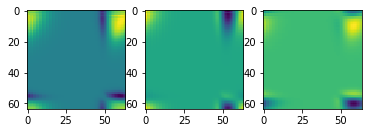

In [3]:
swe_data = np.transpose(np.load('train.npy'))
swe_data_v = np.transpose(np.load('validation.npy'))

swe_train_data = np.zeros(shape=(400,64,64,3)) # Channels last
swe_valid_data = np.zeros(shape=(400,64,64,3)) # Channels last

for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data[i,0:64*64].reshape(64,64)
    temp_2 = swe_data[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data_v[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_v[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_v[i,2*64*64:3*64*64].reshape(64,64)
    swe_valid_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_valid_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_valid_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
# Just to keep things simple
swe_train_data = swe_train_data[0:400,:,:,:]
swe_valid_data = swe_valid_data[0:400,:,:,:]

for j in range(3):
    swe_train_data[:,:,:,j] = (swe_train_data[:,:,:,j] - np.min(swe_train_data[:,:,:,0]))/(np.max(swe_train_data[:,:,:,0])-np.min(swe_train_data[:,:,:,0]))
    swe_valid_data[:,:,:,j] = (swe_valid_data[:,:,:,j] - np.min(swe_valid_data[:,:,:,0]))/(np.max(swe_valid_data[:,:,:,0])-np.min(swe_valid_data[:,:,:,0]))

# Visualize one time instance
time = 20
fig, ax = plt.subplots(nrows=1,ncols=3)

ax[0].imshow(swe_valid_data[time,:,:,0])
ax[1].imshow(swe_valid_data[time,:,:,1])
ax[2].imshow(swe_valid_data[time,:,:,2])
plt.show()

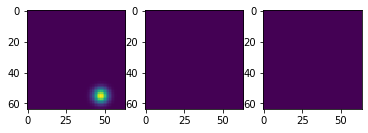

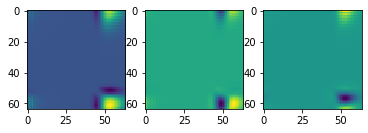

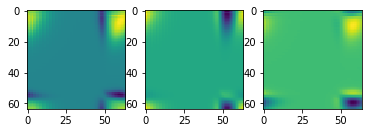

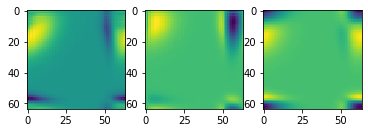

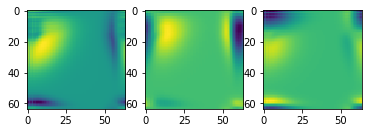

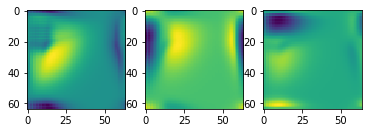

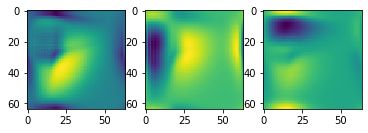

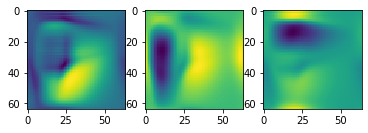

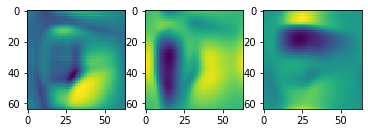

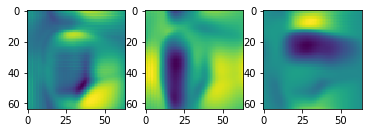

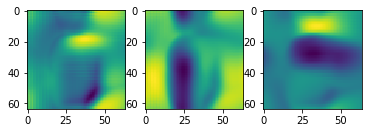

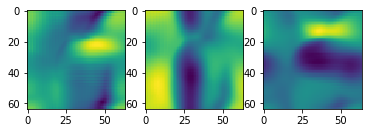

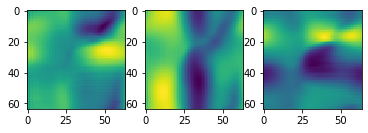

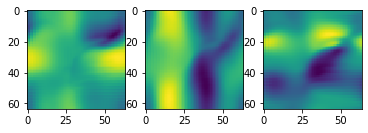

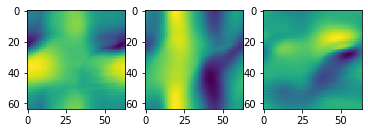

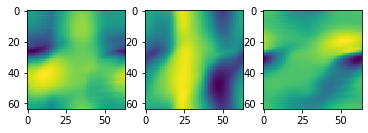

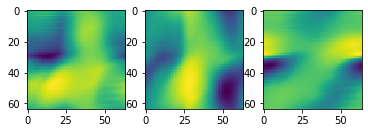

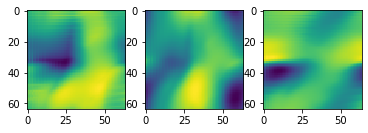

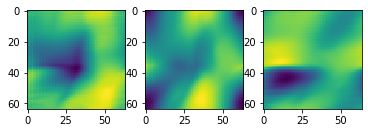

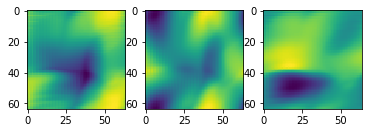

In [4]:
# Visualize multiple time instances
for time in range(0,200,10):
    fig, ax = plt.subplots(nrows=1,ncols=3)
    ax[0].imshow(swe_train_data[time,:,:,0])
    ax[1].imshow(swe_train_data[time,:,:,1])
    ax[2].imshow(swe_train_data[time,:,:,2])
    plt.show()

In [5]:
# Do some shifting to allow for LSTM pipeline
swe_evolve_data = swe_train_data[1:]
swe_train_data = swe_train_data[:-1]

### ML Presets and Custom Functions

In [6]:
mode = 'train'
lrate = 0.001

def mean_absolute_error(y_pred,y_true):
    return K.mean(K.abs(y_true-y_pred))

def max_absolute_error(y_pred,y_true):
    return K.max(K.abs(y_true-y_pred))

### Autoencoder + LSTM pipeline

In [11]:
## Define recursive model architecture
weights_filepath = 'CAE_LSTM_Weights.h5'

# Encoder
encoder_inputs = Input(shape=(64,64,3),name='Field')

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(1,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

encoder = Model(inputs=encoder_inputs,outputs=encoded)

# LSTM
lstm_inputs = Input(shape=(2,2,1),name='LSTM_Inputs')
x = Reshape((1,4))(lstm_inputs)
x = LSTM(20,input_shape=(1,4,),return_sequences=True)(x)
x = LSTM(20,input_shape=(1,4,),return_sequences=True)(x)
x = Dense(4,activation=None)(x)
lstm_outputs = Reshape((2,2,1))(x)
lstm_model = Model(inputs=lstm_inputs,outputs=lstm_outputs)
  
# Decoder
decoder_inputs = Input(shape=(2,2,1),name='decoded')

x = Conv2D(1,kernel_size=(3,3),activation='relu',padding='same')(decoder_inputs)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(5,kernel_size=(3,3),activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

decoded = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')(dec_l5)
    
decoder = Model(inputs=decoder_inputs,outputs=decoded)

# Autoencoder only
ae_outputs = decoder(encoder(encoder_inputs))
# Autoencoder and LSTM pipeline
ae_lstm_outputs = decoder(lstm_model(encoder(encoder_inputs)))

model = Model(inputs=encoder_inputs,outputs=[ae_outputs,ae_lstm_outputs],name='CAE')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[mean_absolute_error,max_absolute_error])    
model.summary()

num_epochs = 5000
batch_size = 4

if mode == 'train':
    train_history = model.fit(x=swe_train_data, y=[swe_train_data,swe_evolve_data], epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2, 2, 1)      9571        Field[0][0]                      
                                                                 Field[0][0]                      
__________________________________________________________________________________________________
model_6 (Model)                 (None, 2, 2, 1)      5364        model_5[2][0]                    
__________________________________________________________________________________________________
model_7 (Model)                 (None, 64, 64, 3)    8583        model_5[1][0]                  

Epoch 12/5000
 99/100 [============================>.] - ETA: 0s - loss: 0.0094 - model_7_loss: 0.0047 - model_7_1_loss: 0.0047 - model_7_mean_absolute_error: 0.0439 - model_7_max_absolute_error: 0.6141 - model_7_1_mean_absolute_error: 0.0440 - model_7_1_max_absolute_error: 0.6104
Epoch 00012: loss did not improve from 0.00937
100/100 [==============================] - 7s 67ms/step - loss: 0.0094 - model_7_loss: 0.0047 - model_7_1_loss: 0.0047 - model_7_mean_absolute_error: 0.0439 - model_7_max_absolute_error: 0.6112 - model_7_1_mean_absolute_error: 0.0439 - model_7_1_max_absolute_error: 0.6075
Epoch 13/5000
100/100 [==============================] - ETA: 0s - loss: 0.0094 - model_7_loss: 0.0047 - model_7_1_loss: 0.0047 - model_7_mean_absolute_error: 0.0438 - model_7_max_absolute_error: 0.5880 - model_7_1_mean_absolute_error: 0.0439 - model_7_1_max_absolute_error: 0.5851
Epoch 00013: loss improved from 0.00937 to 0.00937, saving model to CAE_LSTM_Weights.h5
100/100 [===================

100/100 [==============================] - ETA: 0s - loss: 0.0094 - model_7_loss: 0.0047 - model_7_1_loss: 0.0047 - model_7_mean_absolute_error: 0.0439 - model_7_max_absolute_error: 0.6232 - model_7_1_mean_absolute_error: 0.0440 - model_7_1_max_absolute_error: 0.6215
Epoch 00025: loss did not improve from 0.00936
100/100 [==============================] - 10s 95ms/step - loss: 0.0094 - model_7_loss: 0.0047 - model_7_1_loss: 0.0047 - model_7_mean_absolute_error: 0.0439 - model_7_max_absolute_error: 0.6232 - model_7_1_mean_absolute_error: 0.0440 - model_7_1_max_absolute_error: 0.6215
Epoch 26/5000
100/100 [==============================] - ETA: 0s - loss: 0.0094 - model_7_loss: 0.0047 - model_7_1_loss: 0.0047 - model_7_mean_absolute_error: 0.0439 - model_7_max_absolute_error: 0.6139 - model_7_1_mean_absolute_error: 0.0440 - model_7_1_max_absolute_error: 0.6112
Epoch 00026: loss did not improve from 0.00936
100/100 [==============================] - 10s 97ms/step - loss: 0.0094 - model_7_

KeyboardInterrupt: 

### Check accuracy of autoencoder

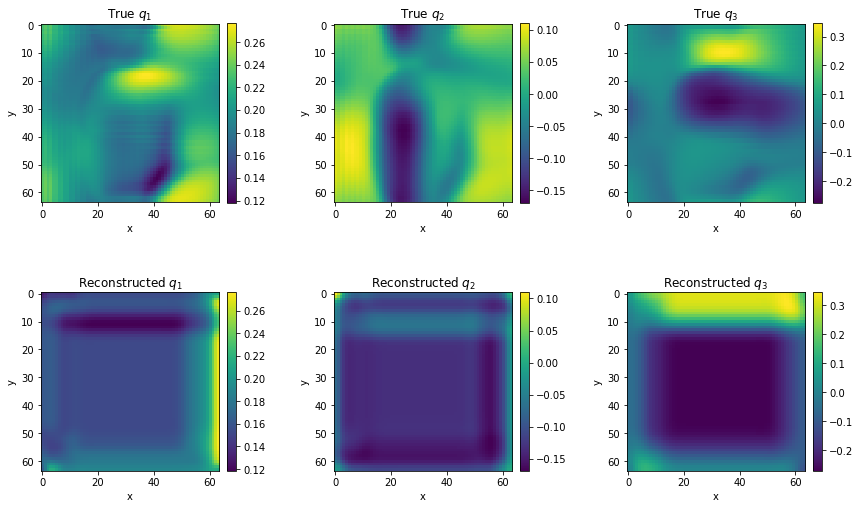

In [13]:
time = 100

model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])[0]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_train_data[time,:,:,0],label='input')
ax[1,0].imshow(gaussian_filter(recoded_1[0,:,:,0],sigma=2),label='decoded')

cs2 = ax[0,1].imshow(swe_train_data[time,:,:,1],label='input')
ax[1,1].imshow(gaussian_filter(recoded_1[0,:,:,1],sigma=2),label='decoded')

cs3 = ax[0,2].imshow(swe_train_data[time,:,:,2],label='input')
ax[1,2].imshow(gaussian_filter(recoded_1[0,:,:,2],sigma=2),label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

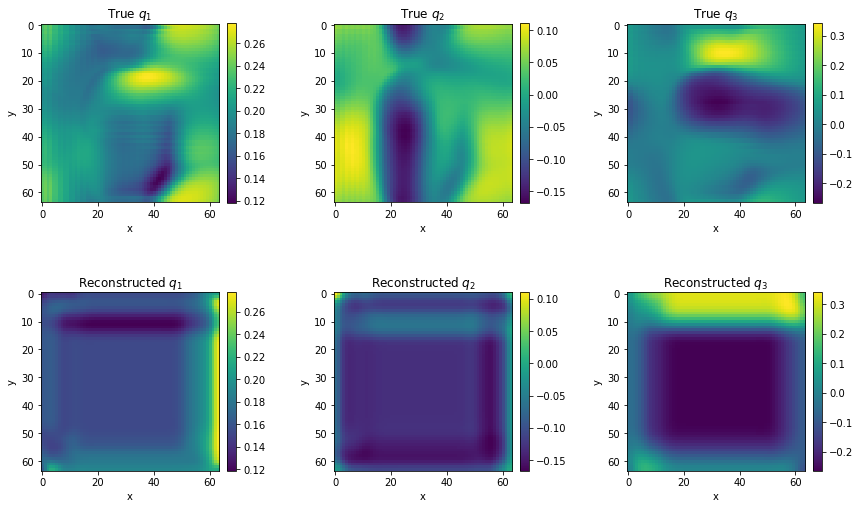

In [14]:
time = 100

model.load_weights(weights_filepath)
from scipy.ndimage import gaussian_filter
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])[1]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_evolve_data[time,:,:,0],label='input')
ax[1,0].imshow(gaussian_filter(recoded_1[0,:,:,0],sigma=2),label='decoded')

cs2 = ax[0,1].imshow(swe_evolve_data[time,:,:,1],label='input')
ax[1,1].imshow(gaussian_filter(recoded_1[0,:,:,1],sigma=2),label='decoded')

cs3 = ax[0,2].imshow(swe_evolve_data[time,:,:,2],label='input')
ax[1,2].imshow(gaussian_filter(recoded_1[0,:,:,2],sigma=2),label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

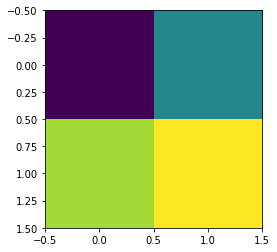

In [19]:
time = 100
encoded = K.eval(encoder(swe_train_data))
plt.imshow(encoded[time,:,:,0])